# [Tensorflow 2.0] 합성곱 신경망: CNN

## 준비하기

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

## CIFAR10 데이터셋

## cifar10 데이터셋을 다운로드

In [22]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

### 픽셀값들을 0과 1사이의 값으로 정규화

In [12]:
train_images, test_images = train_images / 255.0, test_images / 255.0

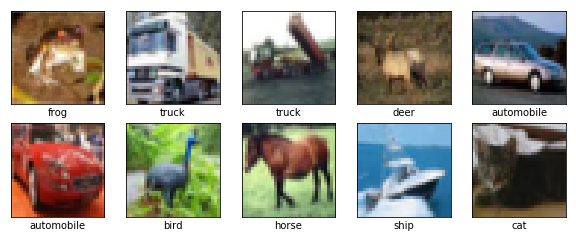

In [13]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Convolutional 기반 만들기

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])

#### 위에 처럼 할 수도 있지만, model.add 방법을 사용해서 tf.keras.layers 반복을 생략할 수 있습니다. 
즉, 비어있는 sequential 모델을 만들고, 레이어를 추가하는 것입니다.

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

###### Convolution과 MaxPooling이란?
1 — Convolution: 이미지에 kernel이나 필터를 적용하는 과정

In [16]:
layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))

##### (3,3): kernel이 3*3 격자무늬
32는 kernel 필터의 개수)

##### 2 — MaxPooling: convoluted 이미지의 최댓값을 줄이는 것(=downsampling)

In [17]:
layers.MaxPooling2D((2, 2))

###### 이제 convoluted 이미지 격자무늬를 만들었는데요, 2X2 kernel을 활용해 최댓값을 뽑는 작업을 해보겠습니다. 
stride값은 2X2 kernel이 픽셀을 몇 개씩 건너뛰어야하는지 할당해주는 값입니다.

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


### 정리
1. 인풋값(32,32)이 no-padding을 통해 (30,30)로 줄어듬
2. 32는 나타날 kernel들의 수. 
각 kernel은 하나의 convoluted 이미지를 갖고, 정리하면, feature map이라고도 불리는 convolution 채널을 총 32개 가지게 됩니다.
3. parameter는 몇 개?
우리는 R, G, B각각에 3*3 픽셀 kernel을 적용시켰습니다. 
3*3*3=27개의 픽셀과, bias kernel을 하나 가집니다. 
정리하면, parameter의 개수는 (27+1)*32=896개 입니다.

4.  2*2 격자무늬로 MaxPooling, 즉 ‘downsampling’을 했습니다. 따라서 feature 개수는 그대로 32개이고, 이미지의 크기는 반으로 15

5. MaxPooling을 적용한 15*15 
featuremap은 convoltion 필터를 통과하며 가장자리가 삭제되어 13*13으로 크기가 줄어듭니다.
이 convolution 레이어(이하 합성곱 레이어)는 3*3픽셀로 구성된 kernel을 64개 갖습니다.
이제 두번째 합성곱 레이어를 만들건데, 음… 64개로 해볼까요?
몇 개의 parameter?
첫번째 합성곱 레이어는 feature map 32개로 구성되었고, 
두번째 레이어는 64개로 구성되었고, 결과적으로 아웃풋 64개를 얻었습니다. 
필터의 사이즈가 3*3이고 개수는 32개 였으므로, 두번째 레이어에서는 총 (3*3*32+1)*64=18496개의 parameter를 가집니다.

6. 개수는 그대로지만, 크기는 또 다시 반으로 줄여졌습니다.

7. no-padding을 적용해서 다시 높이와 너비 모두 2픽셀씩 줄어들었고, 
결과적으로 이 합성곱 레이어는 4*4 픽셀을 갖는 64개의 레이어로 구성됩니다.
몇 개의 parameters?
두번째 합성곱 레이어로부터 우리는 64개의 feature map을 input으로 얻어냈고, 
3*3 필터사이즈를 유지하면서 64개의 feature을 output으로 가졌습니다.
따라서, (3*3*64+1)*64=36928 parameters를 가집니다.
최종적으로 다 합치면, 896+18496+ 36928=56320.

# 맨 위에 Dense layer 추가하기

#### 이제 분류하기 위해서, dense layer가 필요합니다. 
Dense layer는 1차원 벡터를 갖기 때문에, 앞의 convolutional 레이어의 output을 쪼개야 합니다. 
3차원의 (4, 4, 64) tensor를 1차원의 tensor나 4*4*64==1024개 원소로 구성된 벡터로 바꾸겠습니다. 
이를 위해 flatten() layer를 사용하겠습니다.
몇 개의 dense layer를 갖든, 최종 레이어는 softmax 활성화 함수를 활용해 레이어 개수를 클래스 개수와 같은 10개로 만들어야 합니다.

In [23]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

## 모델 편찬하고 학습시키기

In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 59s 37ms/step - loss: 1.5657 - accuracy: 0.4244 - val_loss: 1.2772 - val_accuracy: 0.5411
Epoch 2/10
1563/1563 [==============================] - 57s 36ms/step - loss: 1.2098 - accuracy: 0.5681 - val_loss: 1.1323 - val_accuracy: 0.6031
Epoch 3/10
1563/1563 [==============================] - 57s 37ms/step - loss: 1.0603 - accuracy: 0.6258 - val_loss: 1.0942 - val_accuracy: 0.6178
Epoch 4/10
1563/1563 [==============================] - 56s 36ms/step - loss: 0.9662 - accuracy: 0.6598 - val_loss: 0.9871 - val_accuracy: 0.6494
Epoch 5/10
1563/1563 [==============================] - 57s 36ms/step - loss: 0.8966 - accuracy: 0.6855 - val_loss: 0.9374 - val_accuracy: 0.6701
Epoch 6/10
1563/1563 [==============================] - 55s 36ms/step - loss: 0.8479 - accuracy: 0.7014 - val_loss: 0.9037 - val_accuracy: 0.6808
Epoch 7/10
1563/1563 [==============================] - 58s 37ms/step - loss: 0.8017 - accuracy: 0.7203 - val_loss: 0.8841 -

## 모델 평가하기

In [21]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 4s - loss: 0.8745 - accuracy: 0.7017
